In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
## site-package path in your virtual environment
#sys.path.append("D:\\watanabe\\lib")
#sys.path.append("D:\\watanabe\\lib\\sequence_parser")
#sys.path.append("D:\\watanabe\\lib\\sqe_fitting")
#sys.path.append("D:\\watanabe\\lib\\qcodes_drivers")
## this library path in your virtual environment
#sys.path.append("D:\matsuura\measurement_codes_ut\measurement_codes_ut")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer

# Create session

In [4]:
from measurement_codes_ut.measurement_tool.session import SessionManager as Session
from measurement_codes_ut.measurement_tool.datataking.time_domain import TimeDomainInstrumentManager as TDM

In [5]:
session = Session(
    cooling_down_id='CDY147_ver2', 
    experiment_username='Matsuura', 
    sample_name='hida_FTF2_jjver1_DB4')

# Create TDM - instrument manager

In [6]:
tdm = TDM(session, trigger_address="PXI0::1::BACKPLANE", save_path="D:\matsuura\data")

Creating a new insturment management class for timedomain measurement...done


## Set wiring information text

In [7]:
wiring = "\n".join([
    "readout",
    "E8257D - 1500mm_17H23006 - Fluxonium_cavity_LO",
    "M3202A_slot4_ch1 - 500mm23F09027 - Fluxonium_cavity_IF",
    "Fluxonium_cavity_RF - 1000mm21x07101 - -20db - -10db - -10db - -20dB - -10db - In3C",
    "Out1A - Miteq - 1000mm21x07116 - Fluxonium_read_RF",
    "Fluxonium_read_IF - 500mm - M3201A_slot9_ch1",

    "drive_line",
    "E8257D(lo2) - 1500mm17h23008 - Qubit_LO",
    "M3202A_slot4_ch2 - 500mm23f09026 - 1000mm - 10db - -10db- -3db- In3D",
    
    "bias",
    "Yokogawa GS200 - InB3(Local)"
])

tdm.set_wiring_note(wiring)

## Add control line information

In [8]:
# For readout line
tdm.add_readout_line(
    port_name="readout",
    lo_address="TCPIP0::192.168.100.5::inst0::INSTR",
    lo_power=19,
    awg_chasis=1,
    awg_slot=4,
    awg_channel=1,
    dig_chasis=1,
    dig_slot=9,
    dig_channel=1,
    IQ_corrector=None,
    if_freq=60e6,
    sideband='lower'
)

# For qubit control line
tdm.add_qubit_line(
    port_name="qubit",
    lo_address="TCPIP0::192.168.100.6::inst0::INSTR",
    lo_power=5,
    awg_chasis=1,
    awg_slot=4,
    awg_channel=2,
    IQ_corrector=None,
    if_freq=400e6,
    sideband='lower'
)

# # Current source
# tdm.add_current_source_bias_line(
#     port_name='readout_bias', 
#     current_source_address="TCPIP0::192.168.100.96::inst0::INSTR"
# )

# You can also use add_misc_control_line for e-f, fogi, cloaking etc.

In [9]:
# tdm.current_source['readout_bias'].ramp_current(123e-6, step=1e-7, delay=0)

In [9]:
print(tdm)

*** Allocated devices and channel assignemnt ***
device type          device name          device address                           channel                        port           
-----------------------------------------------------------------------------------------------------------------------------
LO                   E8257D               TCPIP0::192.168.100.5::inst0::INSTR                                     readout        
LO                   E8257D               TCPIP0::192.168.100.6::inst0::INSTR                                     qubit          
AWG                  M3202A                                                        chasis1 slot4 ch1              readout        
AWG                  M3202A                                                        chasis1 slot4 ch2              qubit          
Digitizer            M3102A                                                        chasis1 slot9 ch1              readout        
HVI trigger          M3601A               PXI

# Main

## Initialize calibration note

In [10]:
from measurement_codes_ut.measurement_tool import CalibrationNote
note = CalibrationNote()
note.set_initial_value("pi_pulse_length",120)
note.set_initial_value("cavity_dressed_frequency_cw", 6.745e9)
note.set_initial_value("cavity_dressed_frequency_linewidth_cw", 5e6)
note.set_initial_value("qubit_frequency_cw", 346e6)

## Experiments

In [11]:
tdm.lo, tdm.awg, tdm.digitizer, tdm.hvi_trigger

({'readout': <E82x7: lo_0>, 'qubit': <E82x7: lo_1>},
 {0: <M3202A: awg_0>},
 {'readout': <M3102A: dig_0>},
 <HVI_Trigger: hvi_trigger>)

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment id. 11 completed.


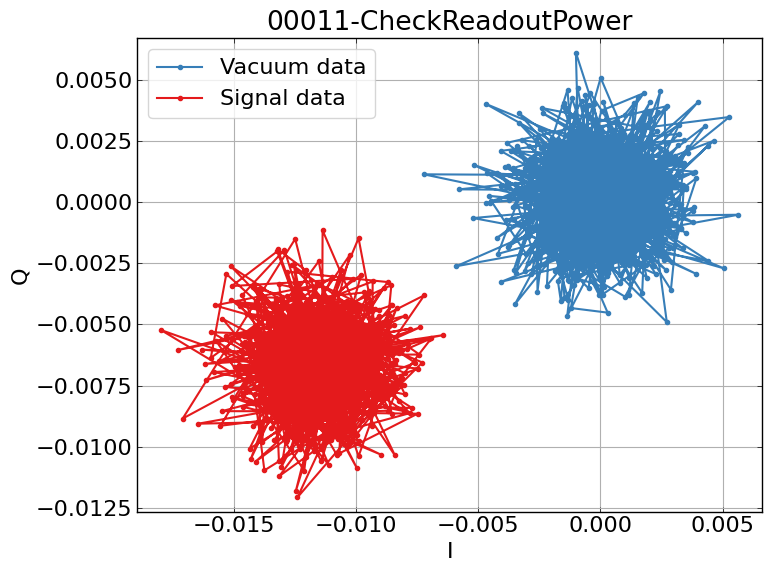

cavity_dressed_frequency_cw : 6745000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.5845334397686334



In [12]:
from measurement_codes_ut.experiment.time_domain.check_readout_power import CheckReadoutPower

exp = CheckReadoutPower(num_shot=1000, expected_sn_ratio=5, trial_amplitude=1)
dataset = exp.execute(tdm, note)
print(note)

In [13]:
from measurement_codes_ut.experiment.time_domain.check_readout_delay import CheckReadoutDelay

exp = CheckReadoutDelay(num_shot=1000)
dataset = exp.execute(tdm, note)

  0%|          | 0/2 [00:00<?, ?it/s]

KeyError: 'amplitude'

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.94it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203237_a77680a5-CheckElectricalDelay/


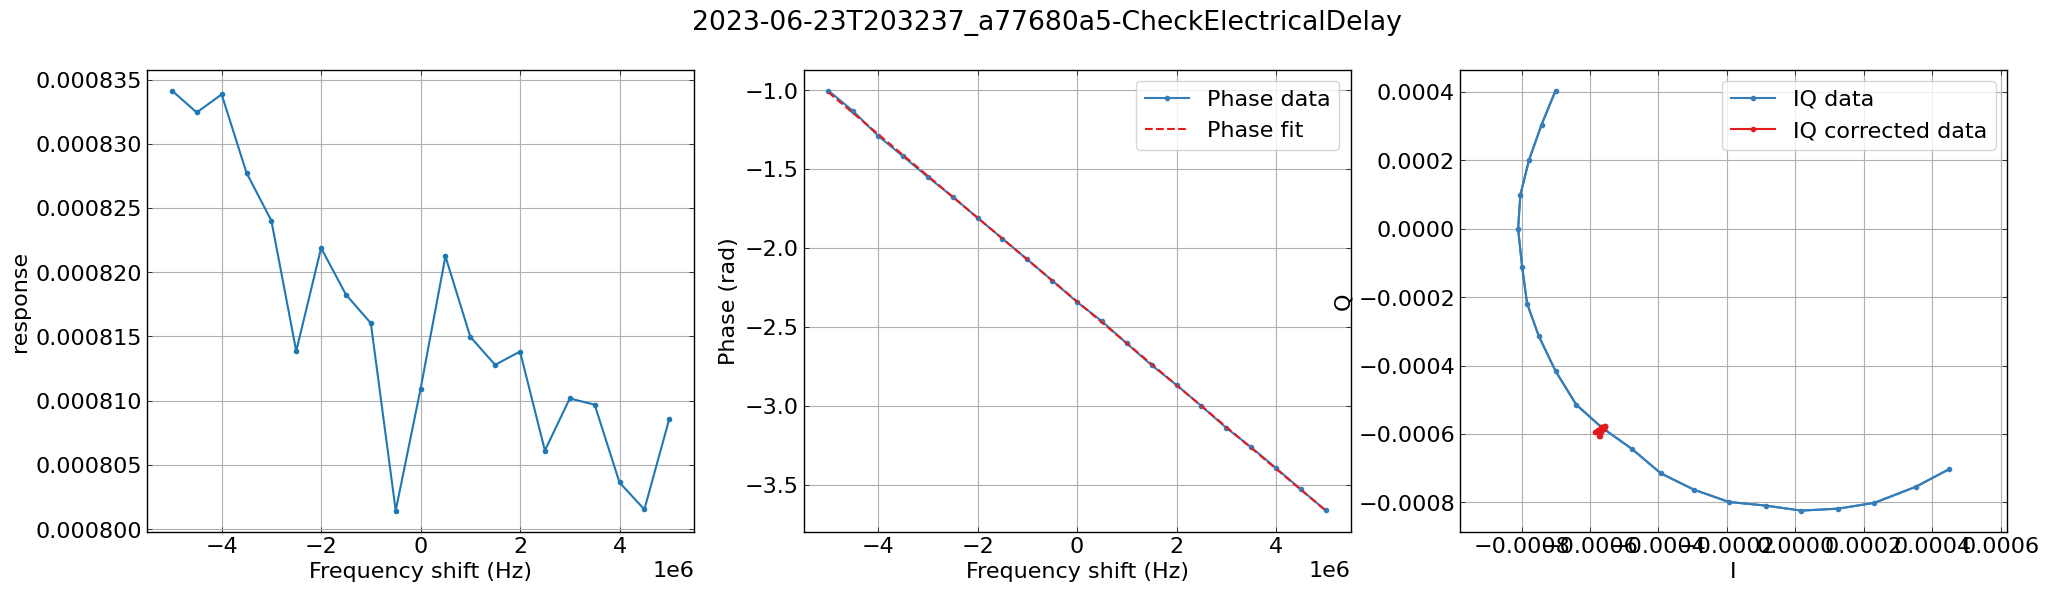

In [15]:
from measurement_codes_ut.experiment.time_domain.check_electrical_delay import CheckElectricalDelay

exp = CheckElectricalDelay(num_shot=1000, sweep_range=10e6, sweep_step=21)
dataset = exp.execute(tdm, note)

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:49<00:00,  4.04it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203243_ab76d3c4-FindCavityPeak/


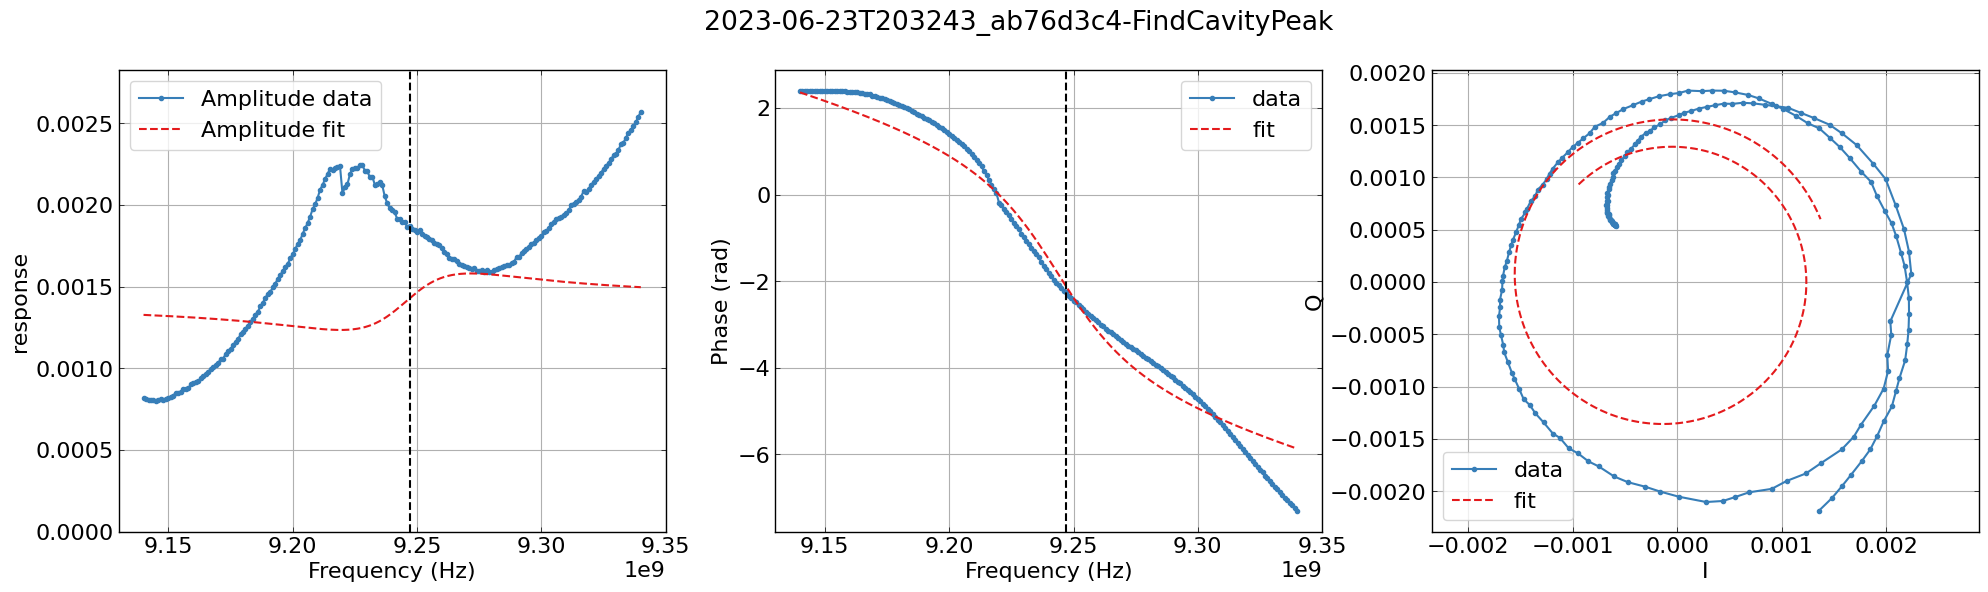

In [16]:
from measurement_codes_ut.experiment.time_domain.find_cavity_peak import FindCavityPeak

exp = FindCavityPeak(num_shot=1000, sweep_range=200e6, sweep_step=201)
dataset = exp.execute(tdm, note)

In [17]:
note.globals.cavity_dressed_frequency.value = 9.23e9

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:27<00:00,  3.69it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203335_ca13b8ff-FindQubitPeak/


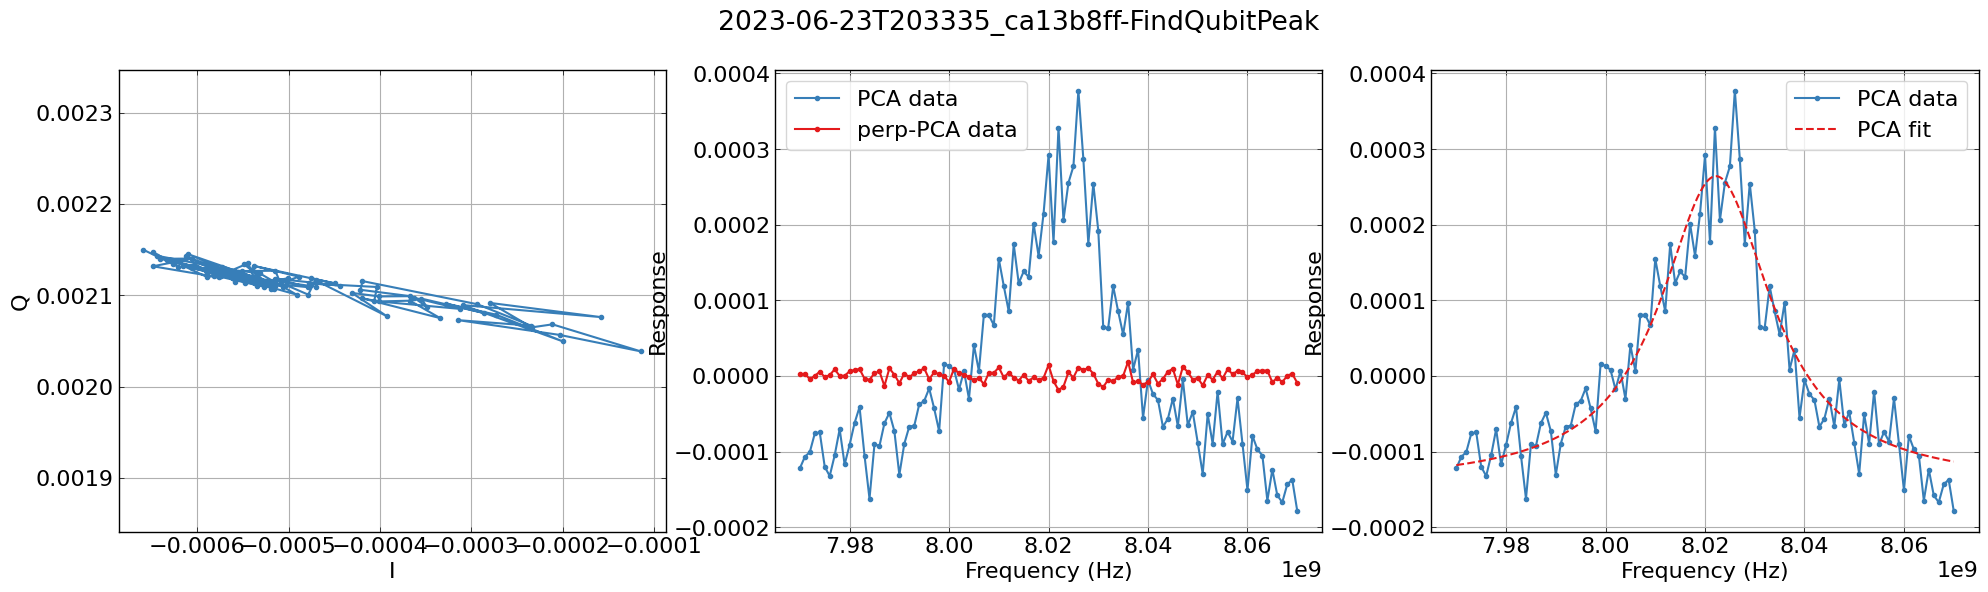

In [18]:
from measurement_codes_ut.experiment.time_domain.find_qubit_peak import FindQubitPeak

exp = FindQubitPeak(num_shot=1000, sweep_range=100e6, sweep_step=101, qubit_pump_amplitude=.25)
dataset = exp.execute(tdm, note)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:26<00:00,  3.77it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203403_db2f3471-FindGFPeak/


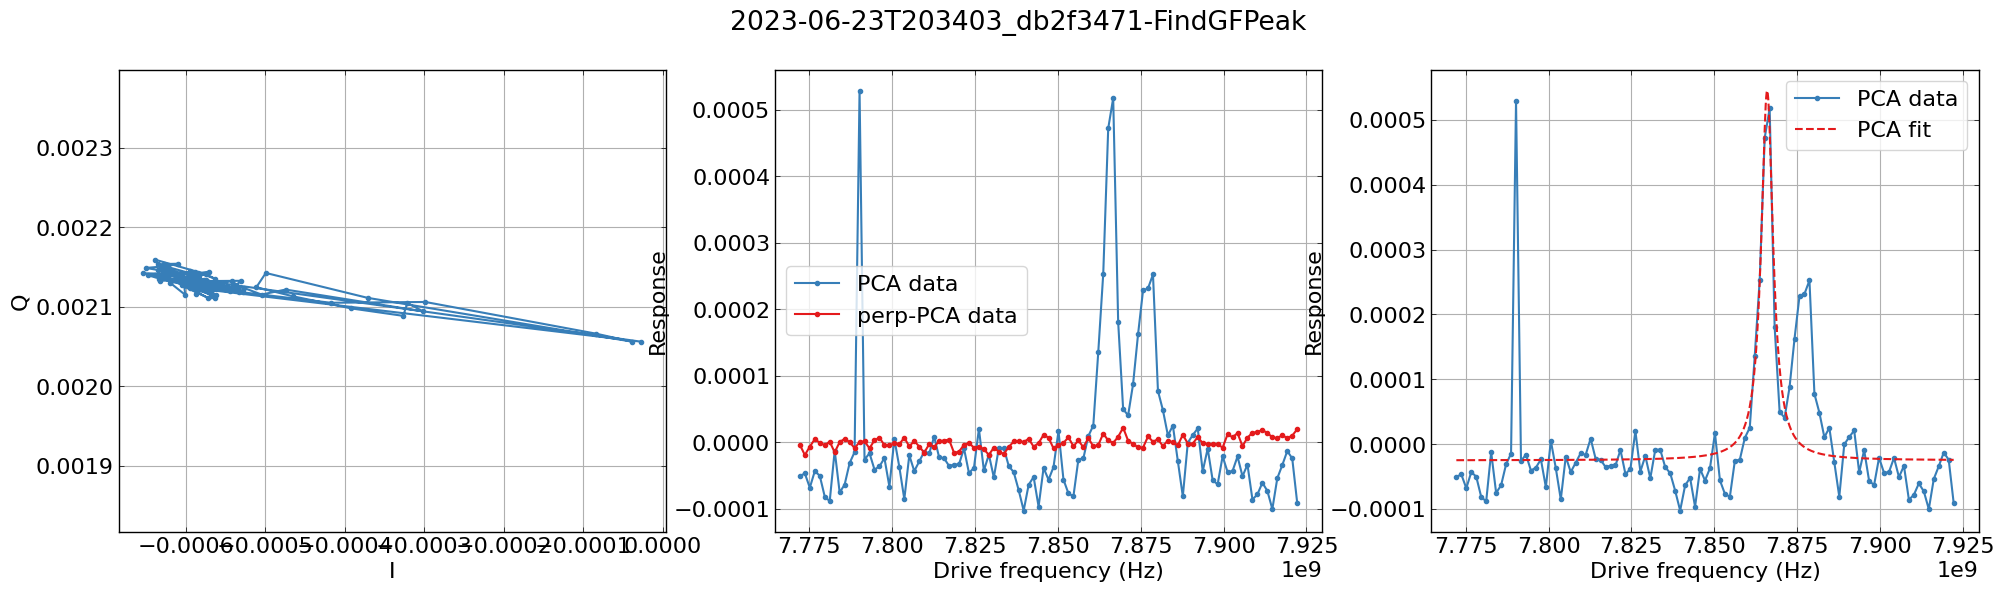

In [19]:
from measurement_codes_ut.experiment.time_domain.find_gf_peak import FindGFPeak

exp = FindGFPeak(num_shot=1000, expected_anharmonicity=-350e6, sweep_range=150e6, sweep_step=101, qubit_pump_amplitude=0.7)
dataset = exp.execute(tdm, note)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.04it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203431_eba41478-CheckRabiOscillation/


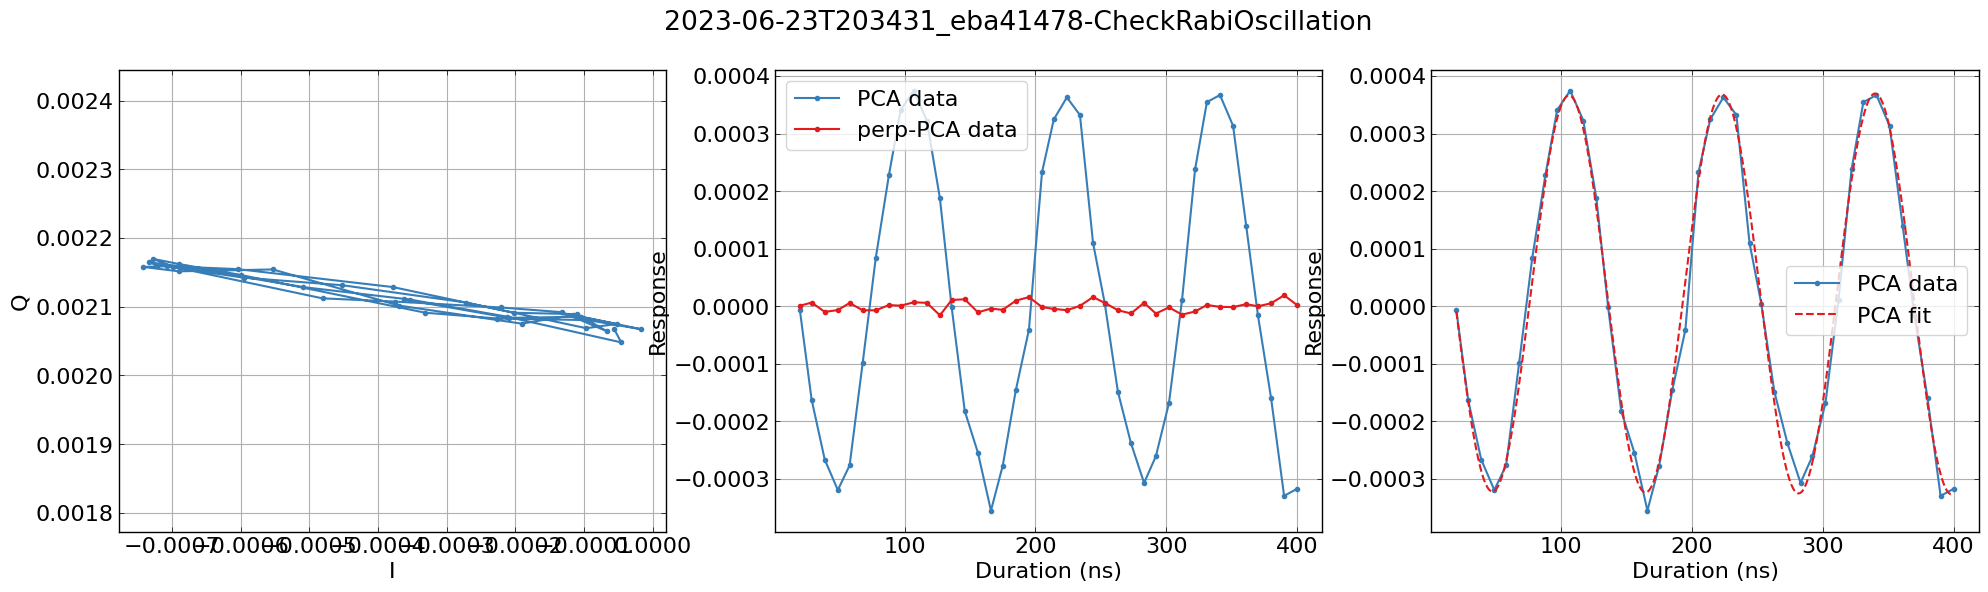

In [20]:
from measurement_codes_ut.experiment.time_domain.check_rabi_oscillation import CheckRabiOscillation

exp = CheckRabiOscillation(num_shot=1000, min_duration=20, max_duration=400)
dataset = exp.execute(tdm, note)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:11<00:00,  3.50it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203452_f8455d7b-CreatePiPulse/


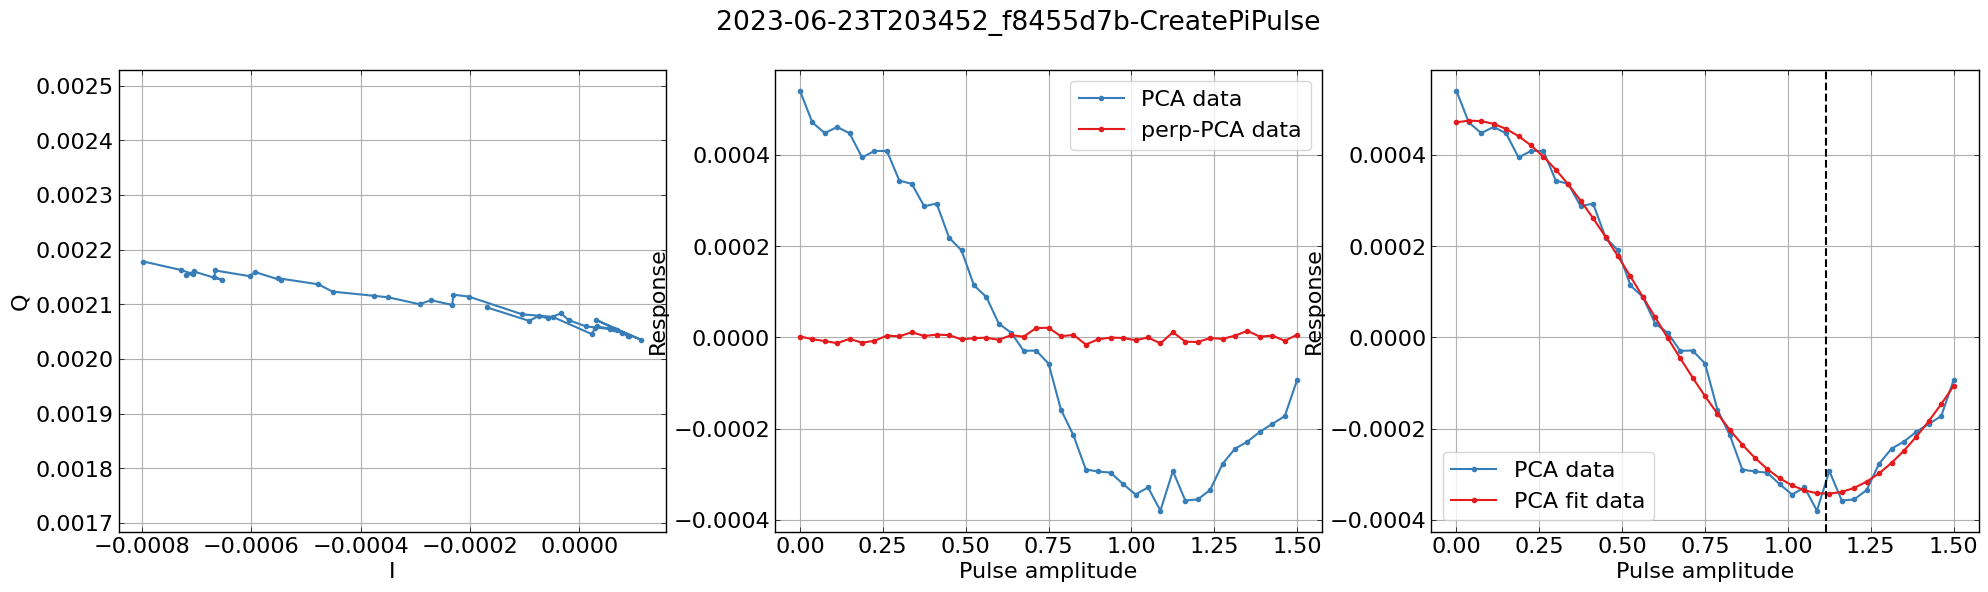

In [21]:
from measurement_codes_ut.experiment.time_domain.create_pi_pulse import CreatePiPulse

exp = CreatePiPulse(num_shot=1000, num_point=41)
dataset = exp.execute(tdm, note)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:11<00:00,  3.52it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203505_ffbad43d-FindDispersiveShift/


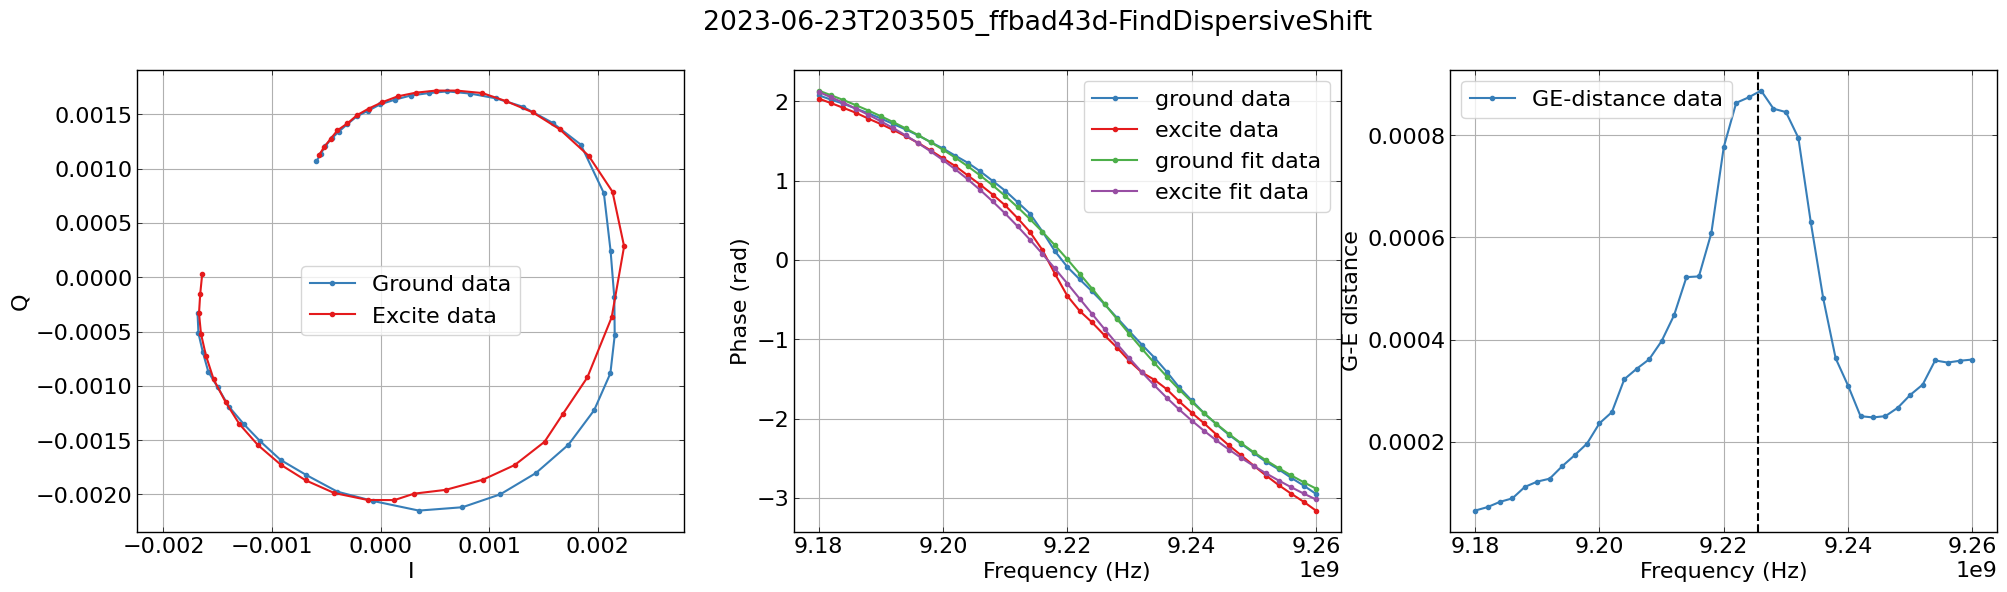

cavity_dressed_frequency_cw : 9240000000.0
cavity_readout_sequence_amplitude_expected_sn : 0.7326369191494565
cavity_readout_trigger_delay : 408.0
cavity_readout_electrical_delay : -4.22051041562981e-08
cavity_dressed_frequency_linewidth_cw : 5000000.0
cavity_dressed_frequency : 9230000000.0
cavity_dressed_frequency_linewidth : 52301094.887078084
cavity_external_decay_rate : 52301014.31654938
cavity_intrinsic_decay_rate : 80.57052869762798
qubit_frequency_cw : 8020000000.0
qubit_dressed_frequency : 8022197905.764786
qubit_full_linewidth : 27259881.165105034
qubit_control_amplitude : 0.25
qubit_dressed_frequency_gf : 7865939970.181767
qubit_anharmonicity : -312515871.1660366
rabi_frequency : 0.008549968526013252
rabi_decay_rate : -4.1315948556219425e-05
rabi_t1 : -24203.72846188634
pi_pulse_length : 40
pi_pulse_power : 1.1145384146971966
cavity_readout_frequency : 9225519127.837671
cavity_dressed_frequency_g : 9227669182.922361
cavity_dressed_frequency_e : 9223424782.740269
dispersive_s

In [22]:
from measurement_codes_ut.experiment.time_domain.find_dispersive_shift import FindDispersiveShift

exp = FindDispersiveShift(num_shot=1000, sweep_range=80e6, sweep_offset=-10e6, num_step=41)
dataset = exp.execute(tdm, note)
print(note)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203529_0e3f8747-OptimizeReadoutPowerAndWindow/


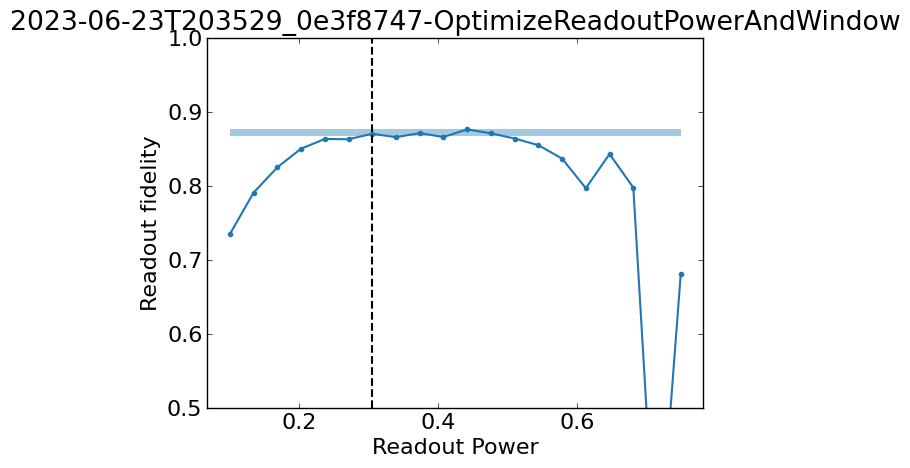

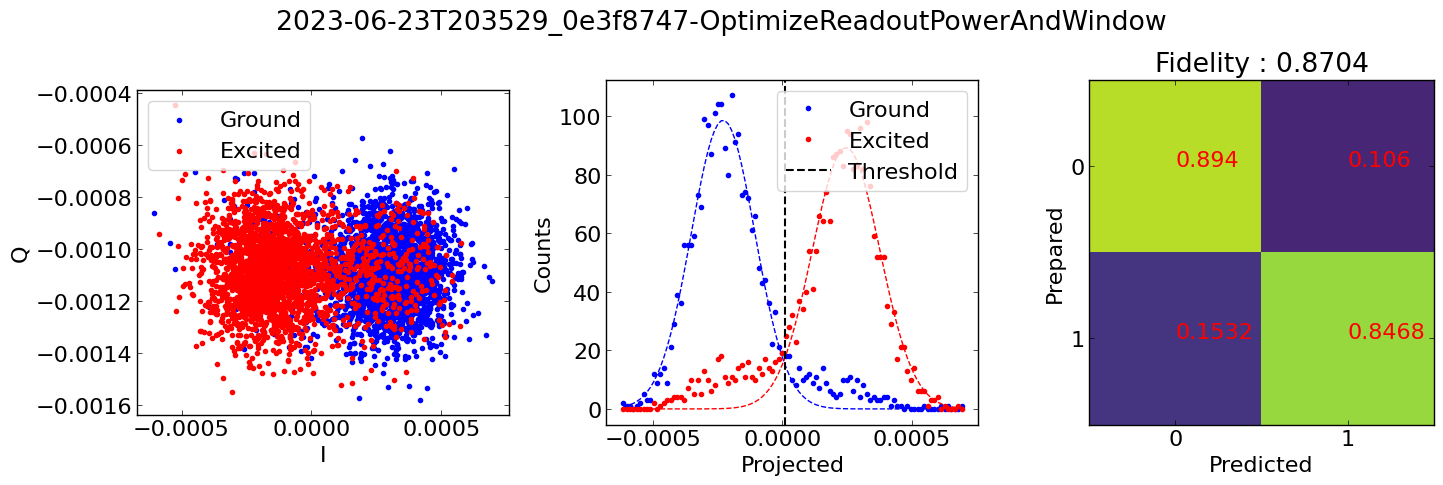

In [23]:
from measurement_codes_ut.experiment.time_domain.optimize_readout_power_and_window import OptimizeReadoutPowerAndWindow

exp = OptimizeReadoutPowerAndWindow(num_shot=2500, num_point=20, min_amplitude=0.1, max_amplitude=0.75, fidelity_fluctuate=0.01)
dataset = exp.execute(tdm, note)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:19<00:00,  2.03it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203620_2cbb6bac-CheckXYRamsey/


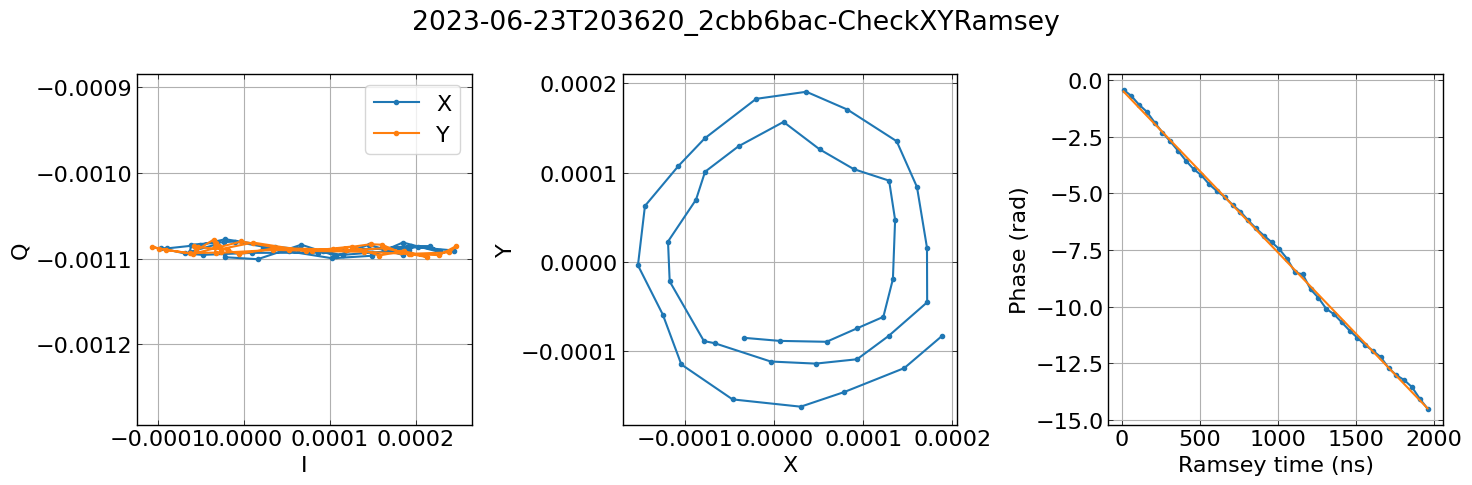

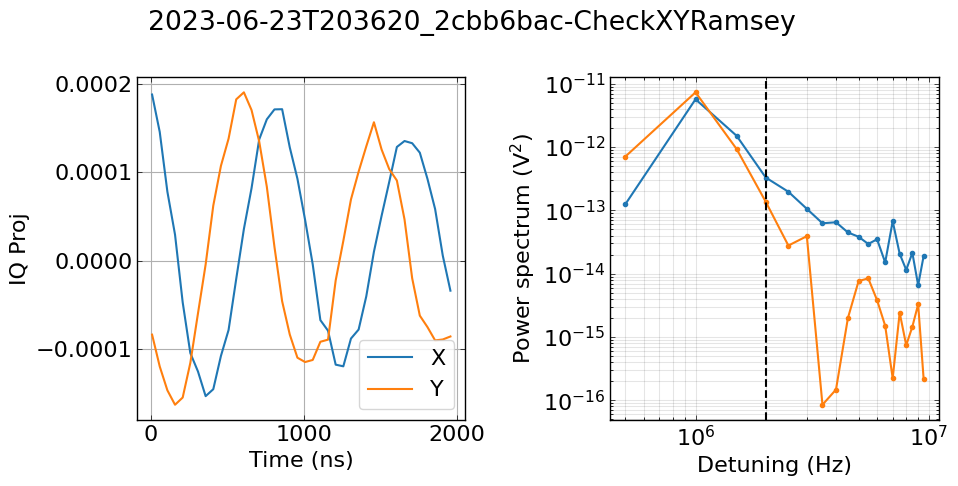

In [24]:
from measurement_codes_ut.experiment.time_domain.check_xy_ramsey import CheckXYRamsey

exp = CheckXYRamsey(num_shot=1000, min_duration=10, max_duration=2000, hand_detune=2e6)
dataset = exp.execute(tdm, note)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.29it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203702_459cdd63-CreatePiPulse/


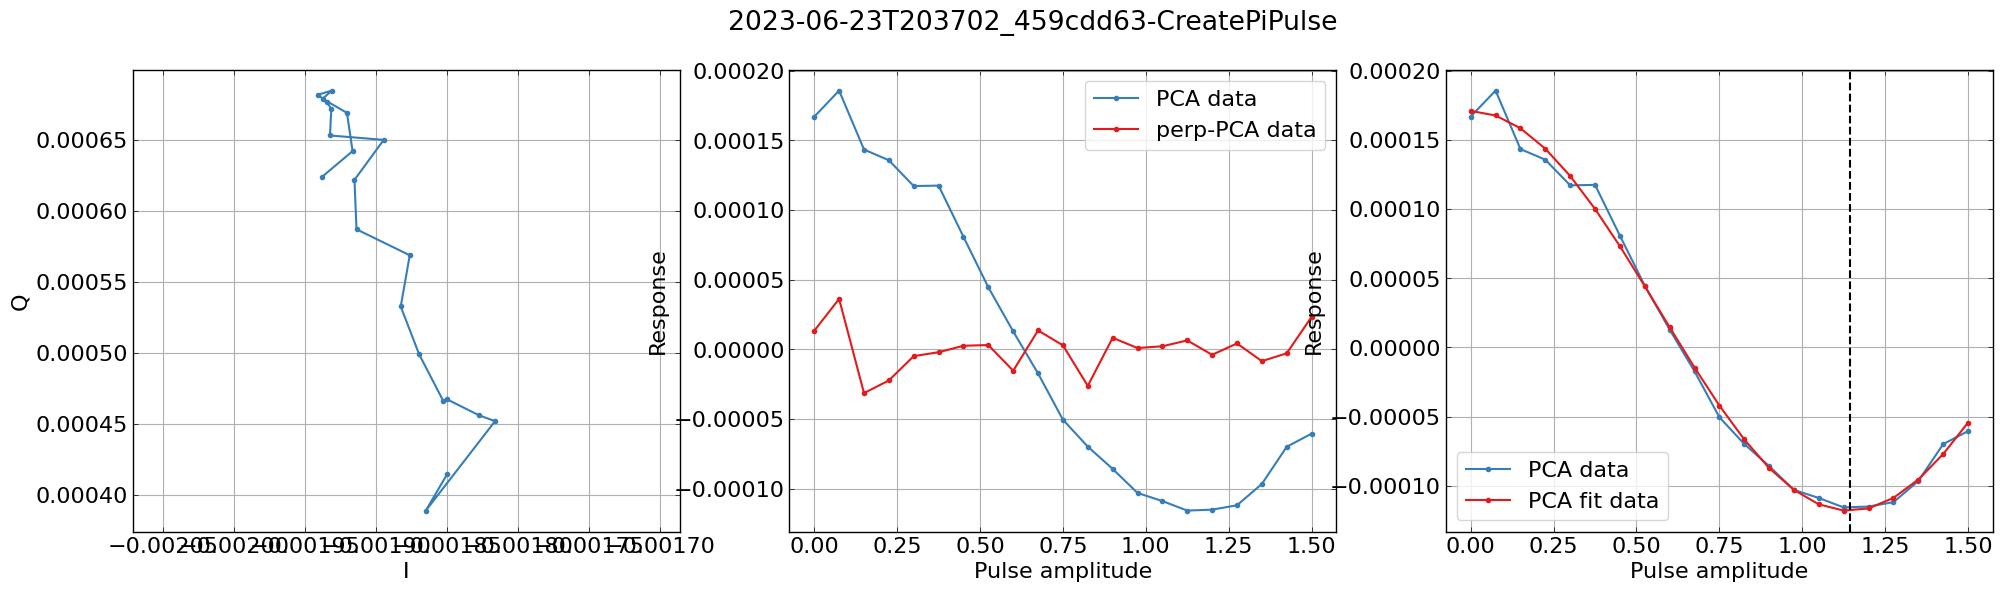

In [25]:
from measurement_codes_ut.experiment.time_domain.create_pi_pulse import CreatePiPulse

exp = CreatePiPulse(num_shot=1000, num_point=21)
dataset = exp.execute(tdm, note)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:26<00:00,  1.95it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203709_49ed8af2-CheckT1Decay/


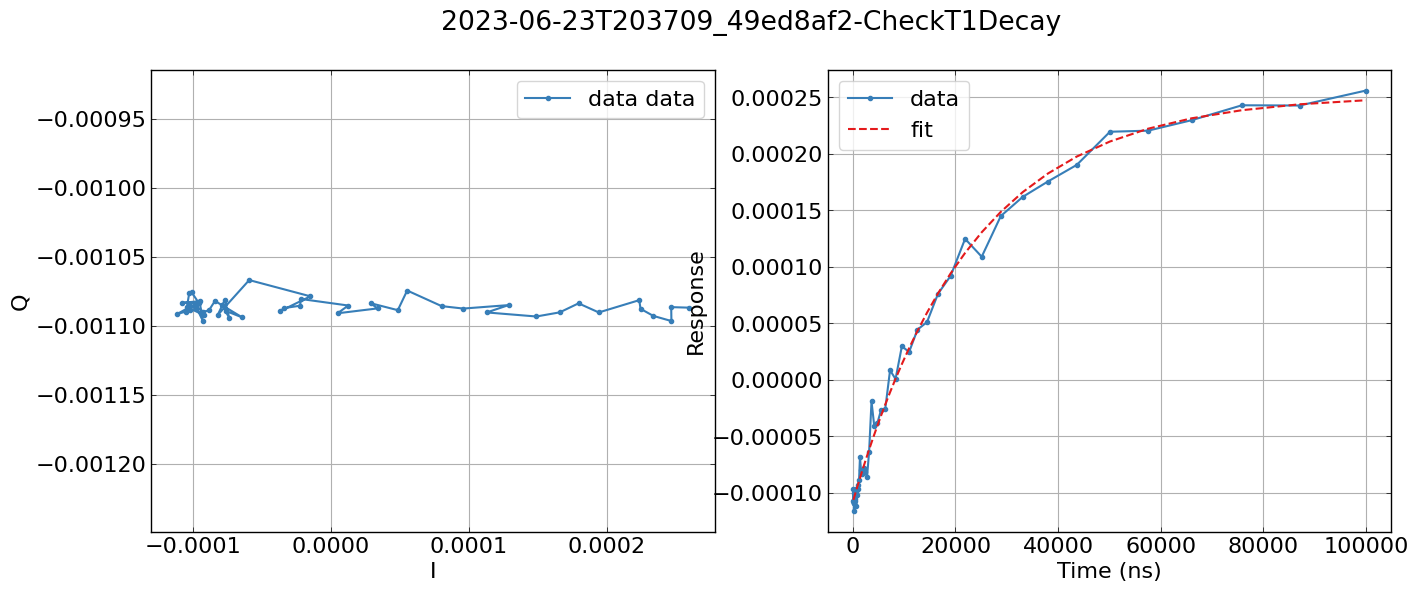

23144.26929684337


In [26]:
from measurement_codes_ut.experiment.time_domain.check_t1_decay import CheckT1Decay

exp = CheckT1Decay(num_shot=1000, min_duration=100, max_duration=100e3, num_sample=51)
dataset = exp.execute(tdm, note)
print(note.t1)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.97it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203736_59ec39cc-CheckT2Ramsey/


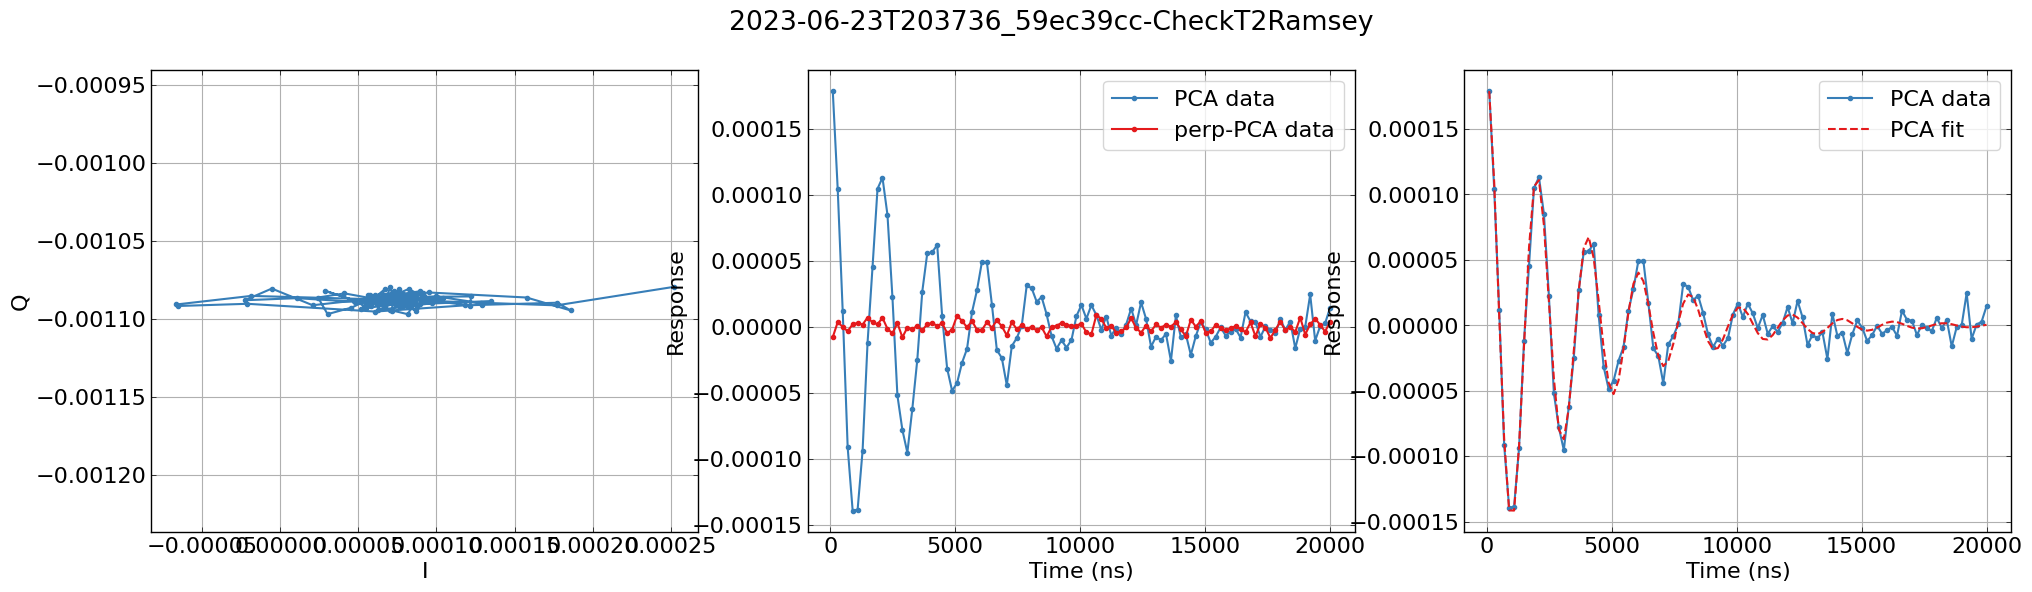

3911.393700714304


In [27]:
from measurement_codes_ut.experiment.time_domain.check_t2_ramsey import CheckT2Ramsey

exp = CheckT2Ramsey(num_shot=1000, min_duration=100, max_duration=20e3, num_sample=101, hand_detune=0.5e6)
dataset = exp.execute(tdm, note)
print(note.t2_star)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.98it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T203828_78fefd41-CheckT2Echo/


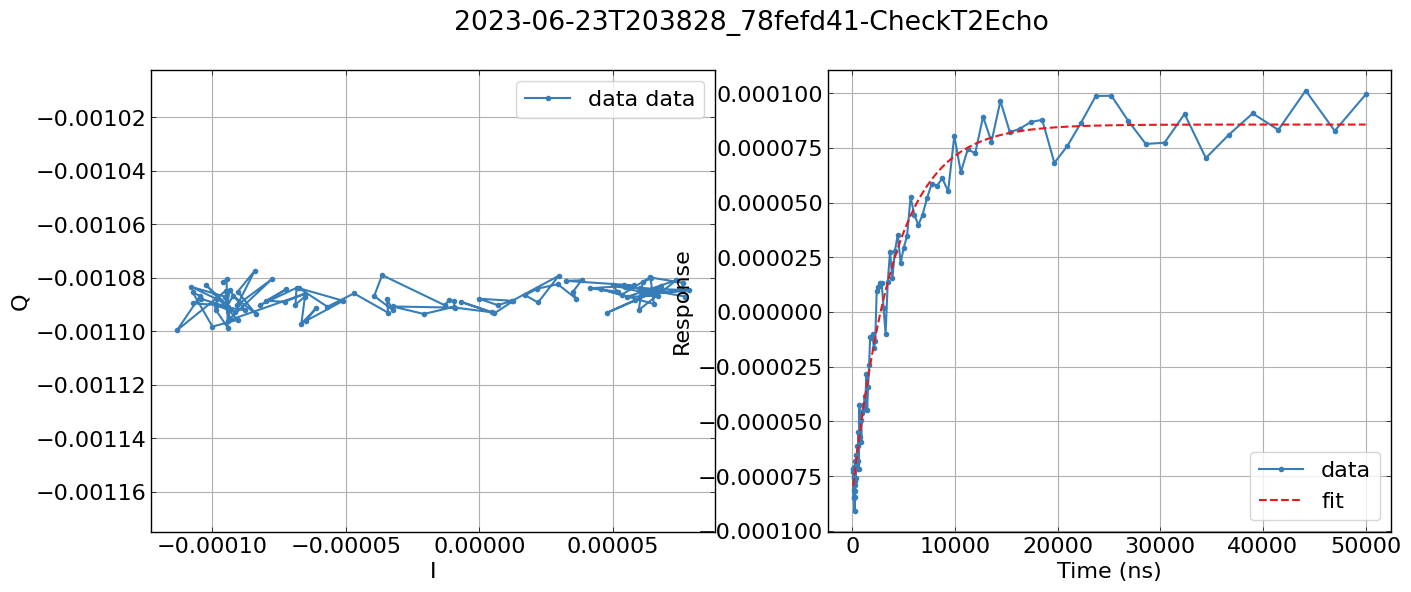

4049.9855626838407


In [28]:
from measurement_codes_ut.experiment.time_domain.check_t2_echo import CheckT2Echo

exp = CheckT2Echo(num_shot=1000, min_duration=100, max_duration=50e3, num_sample=101)
dataset = exp.execute(tdm, note)
print(note.t2_echo)

In [32]:
from measurement_tool.wrapper import AttributeDict
experiment_note = AttributeDict()
experiment_note.half_pi_pulse_power = note.pi_pulse_power
experiment_note.half_pi_pulse_length = note.pi_pulse_length * 0.5
experiment_note.half_pi_pulse_drag = 0

keys = ["half_pi_pulse_power", "half_pi_pulse_length", 
        "half_pi_pulse_drag",]
note.add_experiment_note(keys, experiment_note, keys)

rep = 1


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.53it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204321_2769f4e5-OptimizeHalfPiDRAG/


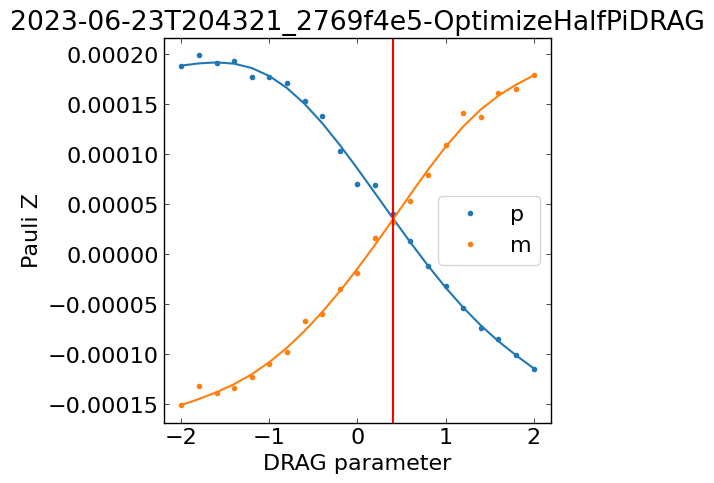

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.52it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204334_2f1d6397-OptimizeHalfPiAmp/


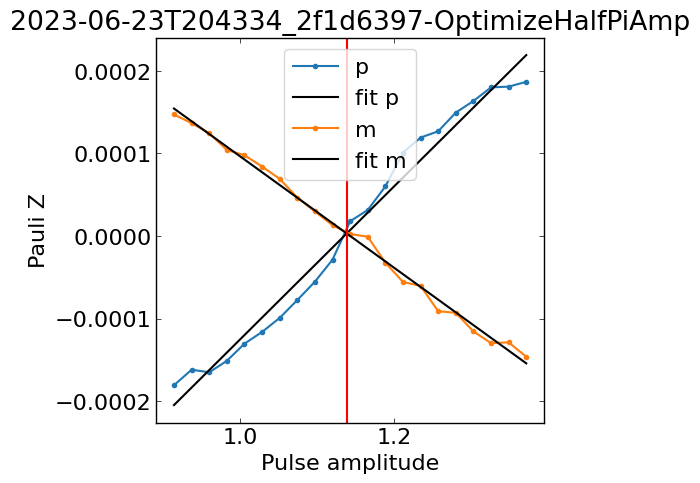

rep = 2


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.40it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204347_36c1749d-OptimizeHalfPiDRAG/


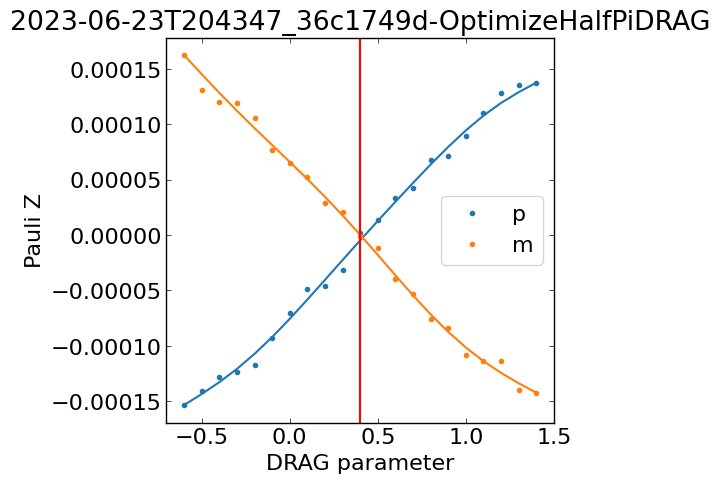

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.50it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204359_3e5a7daf-OptimizeHalfPiAmp/


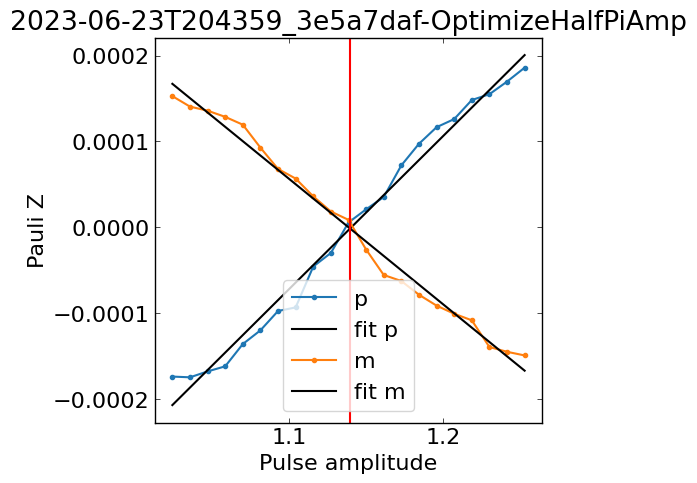

rep = 4


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.32it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204412_45d6f0ba-OptimizeHalfPiDRAG/


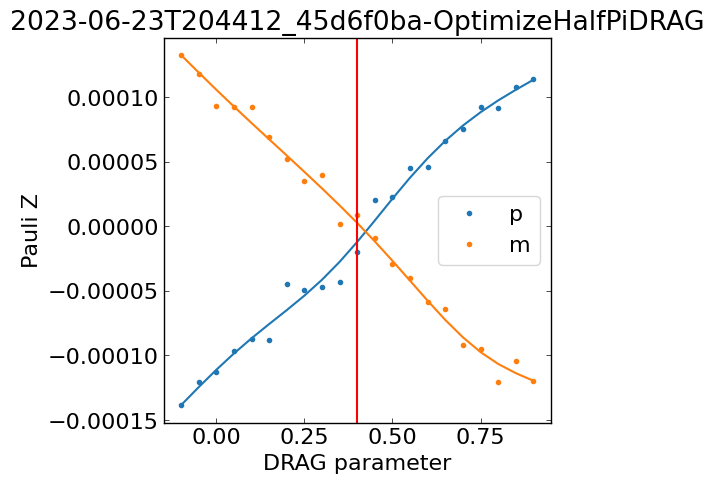

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.39it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204425_4d91a56e-OptimizeHalfPiAmp/


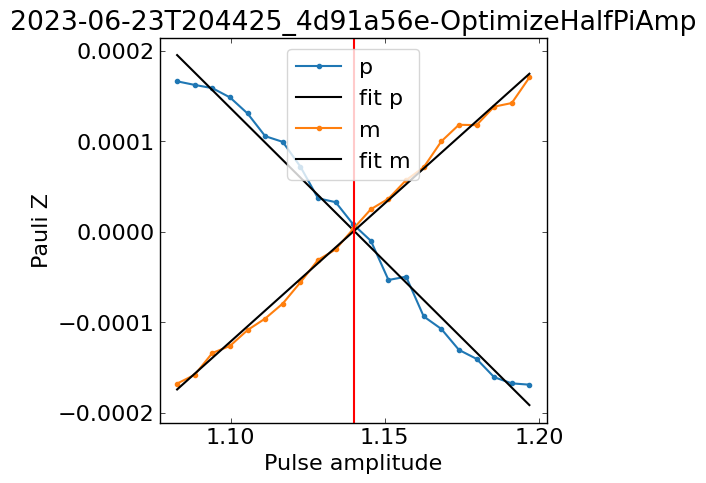

rep = 8


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.44it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204438_556fb42d-OptimizeHalfPiDRAG/


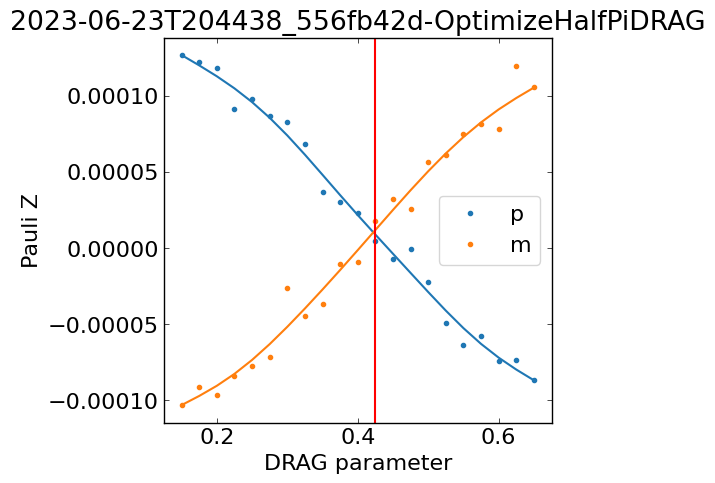

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.40it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204451_5d2763eb-OptimizeHalfPiAmp/


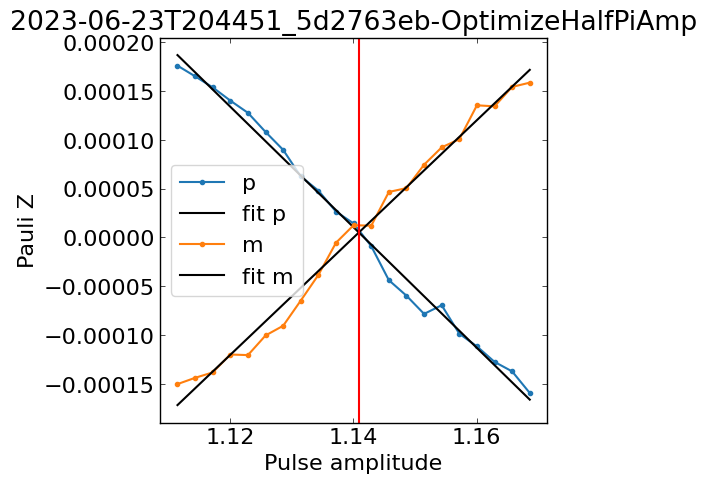

rep = 16


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.37it/s]

Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204504_64fb73d2-OptimizeHalfPiDRAG/


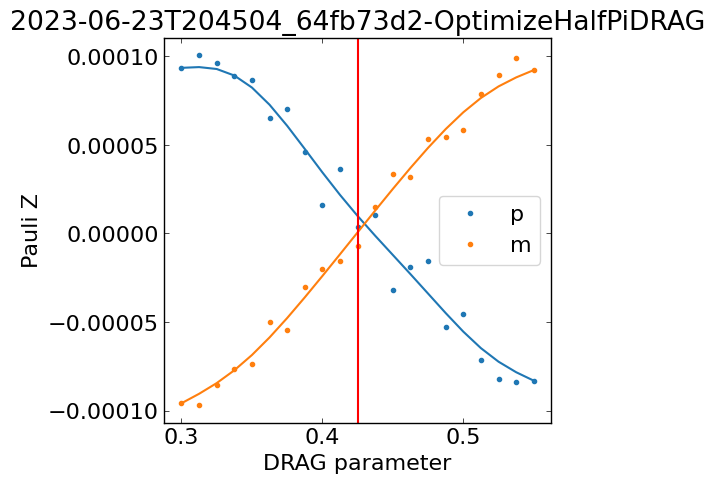

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.27it/s]


Experiment data saved in D:/watanabe/data\2023-06-23/2023-06-23T204518_6d3c9e6e-OptimizeHalfPiAmp/


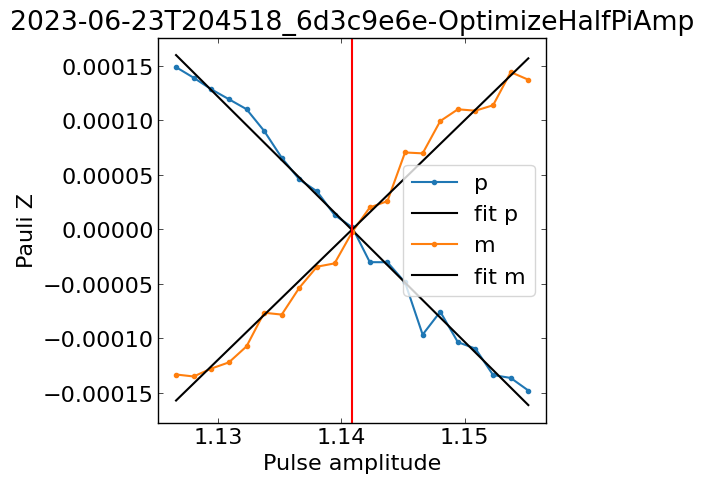

In [33]:
from measurement_codes_ut.experiment.time_domain.optimize_half_pi_pulse_drag import OptimizeHalfPiDRAG
from measurement_codes_ut.experiment.time_domain.optimize_half_pi_pulse_amp import OptimizeHalfPiAmp

amp_range = note.half_pi_pulse_power * np.linspace(0.8, 1.2, 21)
drag_range = np.linspace(-2, 2.,21)

base = 2
rep_list = np.logspace(0,4,5,base=2,dtype=int)
for rep in rep_list:
    print(f"rep = {rep}")
    exp = OptimizeHalfPiDRAG(num_shot=1000, rep=rep, drag_range=drag_range)
    dataset = exp.execute(tdm, note)
    drag_range = exp.drag_center + exp.drag_width/base*np.linspace(-1,1,21)
    
    
    exp = OptimizeHalfPiAmp(num_shot=1000, rep=rep, amp_range=amp_range)
    dataset = exp.execute(tdm, note)
    amp_range = exp.hpi_center + exp.hpi_width/base*np.linspace(-1,1,21)
